# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

### Responses to questions

#### A. Why does the coverage increase slow down as the vocabulary size grows?
This happens because as we increase k, we are adding less frequent words from the corpus into the vocabulary. This leads to the numerator growing less and less with every increase of k, therefore leading to diminishing returns. 
#### B. Which empirical law explains the slowing down increase of the coverage?
The increase slowing down can be explained by Heaps' (Herdan's) Law, which states that as more instance text is gathered, the rate at which unique words are found will continously decrease.

In [1]:
import nltk
import collections
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
nltk.download(['brown'])

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

The ideal vocab size is 8012!


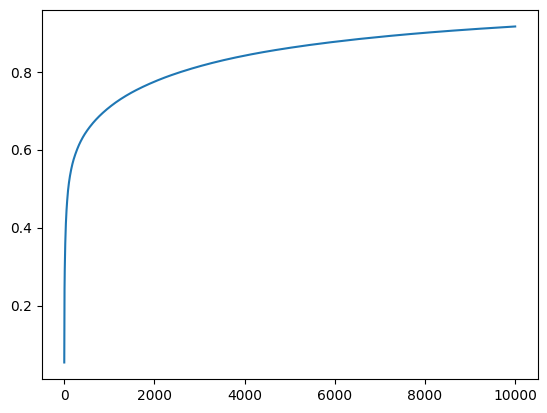

In [2]:
# your code here
corpus = nltk.corpus.brown.words()
freq_calc_corpus = Counter(corpus)
coverage = []
min_vocab_size = 0
for k in range(1, 10000):
    cum_coverage = sum(j for i, j in freq_calc_corpus.most_common(k))/len(corpus)
    coverage.append((k, cum_coverage))
    if cum_coverage > 0.9 and min_vocab_size == 0:
        min_vocab_size = k
print(f"The ideal vocab size is {min_vocab_size}!")
plt.plot(*zip(*coverage))
plt.show()

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [3]:
# your code here
class BPETokenizer:
    def __init__(self):
        """initialize the bpe tokenizer with empty merge list and vocab"""
        self.merges = [] 
        self.vocab = {} 
        self.token_to_id = {}
        
    def get_stats(self, vocab):
        """count frequencies of adjacent symbol pairs in vocab"""
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs
        
    def merge_vocab(self, pair, v_in):
        """merge a pair of symbols across all words in vocab"""
        v_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in v_in:
            w_out = p.sub(''.join(pair), word)
            v_out[w_out] = v_in[word]
        return v_out
        
    def train(self, corpus, vocab_size):
        """
        train the bpe tokenizer on a corpus.
        
        builds merge rules iteratively until desired vocab size reached.
        """
        # count word frequencies in corpus
        word_freqs = {}
        for sentence in corpus:
            words = sentence.split()
            for word in words:
                word_freqs[word] = word_freqs.get(word, 0) + 1
    
        # initialize vocab with characters plus end token
        vocab = {}
        for word, freq in word_freqs.items():
            tokens = ' '.join(list(word)) + ' </w>'
            vocab[tokens] = freq
        
        # get initial vocab size (unique characters)
        unique_chars = set()
        for tokens in vocab.keys():
            for char in tokens.split():
                unique_chars.add(char)
        current_vocab_size = len(unique_chars)
        
        # merge until target vocab size reached
        while current_vocab_size < vocab_size:
            pairs = self.get_stats(vocab)
            if not pairs:
                break
                
            # find and merge the most frequent pair
            best_pair = max(pairs.items(), key=lambda x: x[1])[0]
            
            # store merge rule
            self.merges.append(best_pair)
            
            # apply merge to vocab
            vocab = self.merge_vocab(best_pair, vocab)
            
            current_vocab_size += 1
        
        # store final vocab
        self.vocab = vocab
        
        # build token to id mapping
        all_tokens = set()
        for tokens in vocab.keys():
            for token in tokens.split():
                all_tokens.add(token)
        
        self.token_to_id = {token: idx for idx, token in enumerate(sorted(all_tokens))}
        
        return self.merges
    
    def tokenize(self, text):
        """
        tokenize text using learned merge rules and apply merges in same order as training
        """
        words = text.split()
        encoded_words = []
        
        for word in words:
            # start with character-level tokens
            word_tokens = list(word) + ['</w>']
            
            # apply each merge rule in order
            for merge in self.merges:
                merged = ''.join(merge)
                
                # merge adjacent pairs where possible
                i = 0
                while i < len(word_tokens) - 1:
                    if (word_tokens[i], word_tokens[i+1]) == merge:
                        word_tokens = word_tokens[:i] + [merged] + word_tokens[i+2:]
                    else:
                        i += 1
            
            encoded_words.extend(word_tokens)
        return encoded_words

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [6]:
# your code here
corpus = nltk.corpus.brown.sents()
tokenizer = BPETokenizer()
text_corpus = [' '.join(sent) for sent in corpus[:1000]]
tokenizer.train(text_corpus, vocab_size=min_vocab_size)

fertilities = []
lengths = []

for sentence_words in corpus[:1000]:
    sentence_text = ' '.join(sentence_words)
    tokens = tokenizer.tokenize(sentence_text)
    
    fertility = len(tokens) / len(sentence_words)
    length = len(tokens)
    
    fertilities.append(fertility)
    lengths.append(length)

In [7]:
mean_fertility = np.mean(fertilities)
std_fertility = np.std(fertilities)
mean_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"Mean fertility: {mean_fertility}")
print(f"Std. fertility: {std_fertility}")
print(f"Mean length: {mean_length}")
print(f"Std. length: {std_length}")

Mean fertility: 1.0339146196691782
Std. fertility: 0.11184754465885582
Mean length: 22.705
Std. length: 12.510714408058398


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.